In [1]:
# included modules necessary for the code for this notebook.
import xarray as xr
import os
import numpy as np
import gsw
from netCDF4 import Dataset
import glob
import netCDF4 as nc
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean
from numpy import savetxt
from scipy.stats import skew
import pandas as pd
import csv
from scipy.signal import butter, filtfilt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap


### setting the grid used for all spatial plots

Setting up the grid initially and only needed once for all spatial plots

Loading a set of HF Radar data from the drive to pull the latitude and longitude values necessary for the grided spatial plots
NOTES: I have my data saved to a server - you will pull your data from whereever it is saved


In [ ]:
"""
a = xr.open_mfdataset('/export/data1/jbenjami/Data/SMODE/HF_Radar/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best_2012_01*.nc', parallel=True)
a = load in your you data from wherever you stored it
"""
a=
latitudes = a['lat']
latitude = latitudes[153:264].values
longitudes = a['lon']
longitude = longitudes[449:593].values
uvel = a['u']
au_mean = uvel[:,153:264,449:593].values
vvel = a['v']
av_mean = vvel[:,153:264,449:593].values

In [ ]:
# determining dy - constant over all longitude lines
long = [longitude[25], longitude[25]]
lat1 = [latitude[50], latitude[51]]
lat2 = [latitude[54], latitude[55]]
distance1 = gsw.distance(long, lat1)
distance2 = gsw.distance(long, lat2)

dy = (distance1+distance2)/2

[1999.56086808]
[1999.1366931]


array([1999.34878059])

In [ ]:
# determining dx - not constant over all latitude lines
dxs = []
for i in range(0, len(latitude)):
    long = [longitude[0], longitude[1]]
    lat = [latitude[i], latitude[i]]
    distance = gsw.distance(long, lat)
    dxs.append(distance)
    
dx = np.squeeze(dxs)

In [ ]:
"""
These are the arrays of latitude and longitude on which the velocity derivatives will lie
The derivatives aren't on the generic latitude/longitude grid provided because in computing derivatives 
for vorticity, divergence, strain, etc, the grid gets shifted
"""
dlat = (latitude[1]-latitude[0])/2
lat = latitude + dlat
dlon = np.abs((longitude[0]-longitude[1])/2)
lon = longitude + dlon

### Times series comparison of divergence and kinetic energy flux - Figure 3 (a)

You will need to calculate the divergence for the time series. I did this separately using $\delta$ = $\partial$u/$\partial$x + $\partial$v/$\partial$y

BEFORE: I tidally filtered all the velocities - a 48-hour windowed average to eliminate tidal effects (as with the vorticity for Figure 1)

Then load the data in - since I calculated and saved the data separately, I am merely pulling the saved data here, spatially averaged over the same Santa Barabra region as in all the time series. You can do your own calculations.

But since there is 12 years worth of data, I did the calculations separately so it did run everytime I wanted to make an edit to the figure.

Loading in the divergence data calculated and the flux to show the correlation between the two properties

In [7]:
Flux = np.loadtxt('/export/data1/staylor2/HF Radar/scripts/GRL figures/Flux.txt')
filtereddiverg = np.loadtxt('/export/data1/staylor2/HF Radar/scripts/GRL figures/filtereddiverg.txt')
filtereddiverg7 = np.loadtxt('/export/data1/staylor2/HF Radar/scripts/GRL figures/filtereddiverg7.txt')
filteredstrain = np.loadtxt('/export/data1/staylor2/HF Radar/scripts/GRL figures/filteredstrain.txt')

In [7]:
# Load in your data series as appropriate
Flux =  # kinetic energy flux time series
filtereddiverg = # full divergence field time series
filtereddiverg7 = # divergence field time series at scales smaller than 7 km


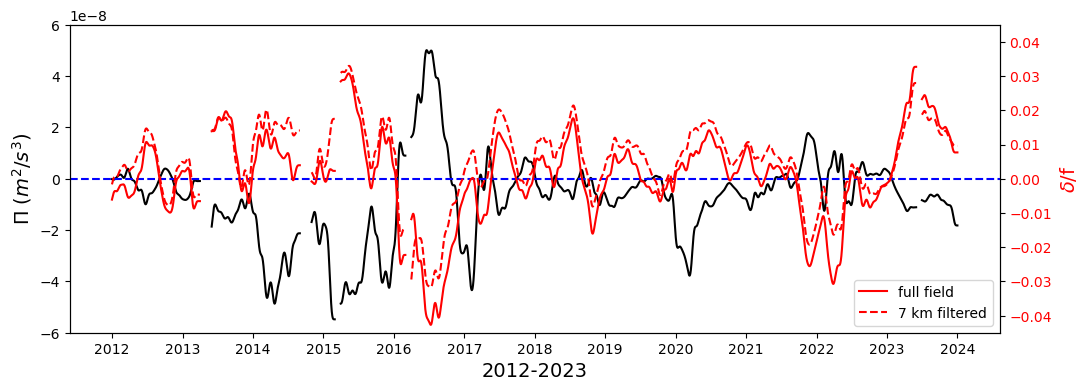

In [8]:
# two axis deal to compare magnitudes
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(Flux, 'k-')
ax1.set_ylabel(r'$\Pi$ ($m^2/s^{3}$)', color='k', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(filtereddiverg, 'r-', label = 'full field')
ax2.set_ylabel(r'$\delta$/f', color='r', fontsize=14)
ax2.plot(filtereddiverg7, 'r--', label = '7 km filtered')
ax2.legend(loc='lower right')

ax2.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='y', labelcolor='black')
tickpositions = [0, 8784,17544, 26304, 35064, 43848, 52608, 61368, 70128, 78912, 87672, 96432, 105191]
ticklabels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'] 
plt.xticks(tickpositions, ticklabels)
ax1.set_xlabel('2012-2023', fontsize=14)
ax1.set_ylim(-6e-8,6e-8)
ax1.axhline(y=0, c='b', linestyle='--')
ax2.set_ylim(-0.045, 0.045)
plt.savefig("Fluxdivergtimeseries.jpg", dpi=300)
plt.show()

### Spatial plots of the $\Pi$ and $\delta$ to show correlation - Figure 3 (b) and (c)

Snapshots of the kinetic energy flux and divergence in the Santa Barbara CHannel averaged from January 2015-July 2015 to show the anticorrelation between the two properties in space

In [67]:
# loaded in the kinetic energy flux for January - July 2015 to plot (the calculations were completed separately as described in other notebooks)
pispatial = np.concatenate((Jan4pi7, Feb4pi7, March4pi7, April4pi7, May4pi7, June4pi7, July4pi7), axis=0) # this is just how I saved it on my side for each month
divergspatial = diverg1518[0:5084,:,:] # also loading in the divergence for the same time 

In [1]:
# averaging over time rather than space to retain the spatial function
PiSpat = np.nanmean(pispatial, axis=0)
DivergSpat = np.nanmean(divergspatial, axis=0)

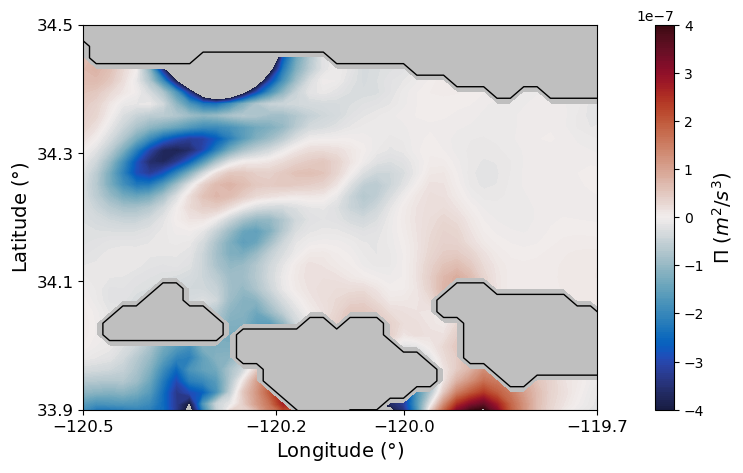

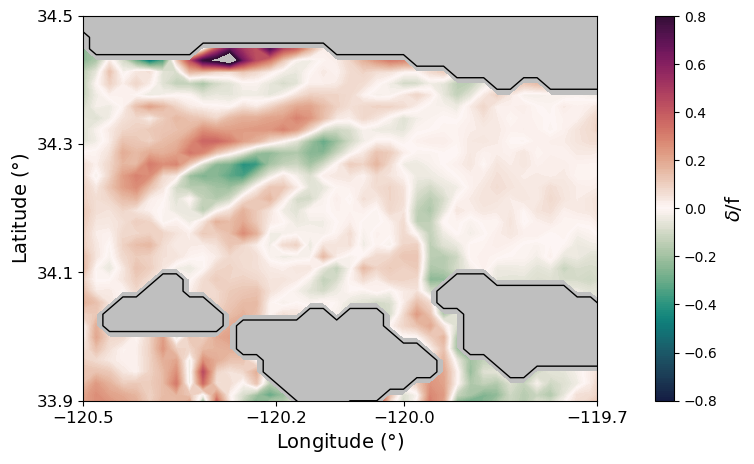

In [ ]:
"""
There is extra code here to create the border outlines of the land masses 
but overall showing the spatial plots of the kinetic energy flux and the divergence for the Santa Barbara Channel
"""
masked_data = np.ma.masked_invalid(PiSpat)

fig, ax = plt.subplots(figsize=(15,5))
contour = ax.contourf(lon[:-1], lat[:-1], masked_data, cmap=cmocean.cm.balance, levels=np.linspace(-.4e-6,.4e-6, 200))

nan_mask = np.isnan(PiSpat)
ax.imshow(nan_mask, cmap=ListedColormap(['grey']), interpolation='nearest', alpha=0.5, extent=ax.get_xlim() + ax.get_ylim())
ax.contour(lon[:-1], lat[:-1], nan_mask, levels=[0.5], colors='black', linewidths=1)

cbar = plt.colorbar(contour)
plt.xlim(-120.5,-119.7)
plt.ylim(33.9,34.5)
plt.xlabel('Longitude ($\degree$)', fontsize=14)
plt.ylabel('Latitude ($\degree$)', fontsize=14)
# cbar=plt.colorbar()
cbar.set_label(r'$\Pi$ ($m^2/s^3$)', fontsize=14)
cbar.set_ticks([-4e-7,-3e-7,-2e-7,-1e-7,0,1e-7,2e-7,3e-7,4e-7])
plt.xticks([-120.5, -120.2, -120, -119.7], fontsize=12)
plt.yticks([33.9, 34.1, 34.3, 34.5], fontsize=12)
plt.savefig("Fluxspatialplot.jpg", dpi=300)
plt.show()

masked_data = np.ma.masked_invalid(DivergSpat)

fig, ax = plt.subplots(figsize=(15,5))
contour = ax.contourf(lon[:-1], lat[:-1], masked_data, cmap=cmocean.cm.curl, levels=np.linspace(-.8,.8, 200))

nan_mask = np.isnan(DivergSpat)
ax.contour(lon[:-1], lat[:-1], nan_mask, levels=[0.5], colors='black', linewidths=1)
ax.imshow(nan_mask, cmap=ListedColormap(['grey']), interpolation='nearest', alpha=0.5, extent=ax.get_xlim() + ax.get_ylim())

cbar = plt.colorbar(contour)
plt.xlim(-120.5,-119.7)
plt.ylim(33.9,34.5)
plt.xlabel('Longitude ($\degree$)', fontsize=14)
plt.ylabel('Latitude ($\degree$)', fontsize=14)
cbar.set_label(r'$\delta$/f', fontsize=14)
plt.xticks([-120.5, -120.2, -120, -119.7], fontsize=12)
plt.yticks([33.9, 34.1, 34.3, 34.5], fontsize=12)
cbar.set_ticks([-.8,-.6,-.4,-.2,0,.2,.4,.6,.8])
plt.savefig("Divergspatialplot.jpg", dpi=300)
plt.show()

### $\Pi$ conditioned on divergence and strain - Figure 3 (d)

Will need to load in the strain field for this comparison. Again, this was calculated separately using the formulation:
$\alpha$ = $\sqrt{\sigma_s^2+\sigma_n^2}$ where $\sigma_s$ = $\partial$v/$\partial$x + $\partial$u/$\partial$y and $\sigma_n$ = $\partial$u/$\partial$x - $\partial$v/$\partial$y

You will need to load in your full divergence, strain, and flux data sets, unaveraged spatially or temporally

In [7]:
# loading in divergence smaller than 7 km to compare formulations, the f notating that the values have been normalized by the coriolis frequency
divergf = 
alphaf = 
pi = 

In [ ]:
x = divergf[:,61:78,28:62].flatten()
y = alphaf[:,61:78,28:62].flatten()
colors = pi[:,61:78,28:62].flatten()


numbins = 100
concentration = []
xbins = np.linspace(np.nanmin(x),np.nanmax(x),numbins)
ybins = np.linspace(0, np.nanmax(y), numbins)
averagepi = []
for i in range(0, numbins-1):
    for j in range(0, numbins-1):

        x_min, x_max = xbins[i], xbins[i+1]
        y_min, y_max = ybins[j], ybins[j+1]

        selected_points = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)

        selected_x = x[selected_points]
        selected_y = y[selected_points]
        selected_colors = colors[selected_points]
        # print(selected_colors)
        concentration.append(len(selected_colors))
        average_value = np.nanmean(selected_colors)
        averagepi.append(average_value)

# print(averagepi)
divergaxis = []
strainaxis = []
for i in range(0, numbins-1):
    xaxis = (xbins[i]+xbins[i+1])/2
    divergaxis.append(xaxis)
    yaxis = (ybins[i]+ybins[i+1])/2
    strainaxis.append(yaxis)

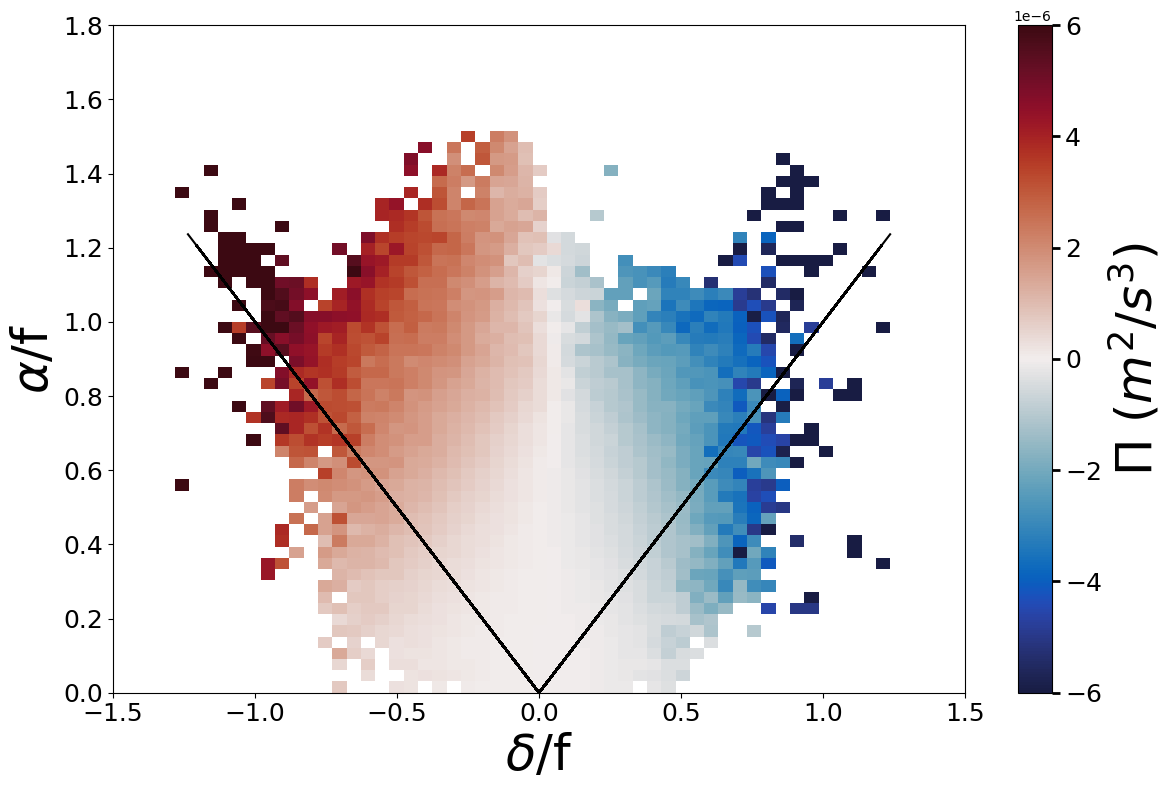

In [120]:
plt.figure(figsize=(12,8))
sc = plt.pcolormesh(divergaxis, strainaxis, np.reshape(averagepi, ((numbins-1),(numbins-1))).T, cmap=cmocean.cm.balance, vmin=-6e-6, vmax=6e-6)
colorbar = plt.colorbar(sc)
colorbar.set_label(r"$\Pi$ ($m^2$/$s^3$)", fontsize=36)
plt.plot(x,x, c='k')
plt.plot(-x,x, c='k')
plt.xlim(-1.5,1.5)
plt.ylim(0, 1.8)
plt.xlabel(r"$\delta$/f", fontsize=36)
# plt.title('relationship between strain, divergicity and flux')
plt.ylabel(r"$\alpha$/f", fontsize=36)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
colorbar.ax.tick_params(labelsize=18)  # Set font size for colorbar tick labels
colorbar.ax.tick_params(axis='both', length=6, width=2)  # Set length and width of colorbar ticks
plt.tight_layout()
plt.show()